 <font size="6"><center><b>
    Mоделирование такта сжатия многотопливного малооборотного судового дизельного двигателя
 </b></center></font>

In [ ]:
'''----------------------------------------------------------------------------
       ___       |
     _|o_ |_     |   Language: Python 3.x
    /  ___| \    |   Website: https://github.com/StasF1/dualFuelEngine
    \_| ____/    |   Copyright (C) 2018-2020 Stanislau Stasheuski
      |__o|      |
-------------------------------------------------------------------------------
License
    This file is part of dualFuelEngine – OpenFOAM addition.

    dualFuelEngine (like OpenFOAM) is free software: you can redistribute it 
    and/or modify it under the terms of the GNU General Public License as
    published by the Free Software Foundation, either version 3 of the License,
    or (at your option) any later version.

    dualFuelEngine (like OpenFOAM) is distributed in the hope that it will be
    useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
    See the GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this repository. If not, see <http://www.gnu.org/licenses/>.

File
    Man_BnW.ipynb

Description
    MAN_BnW Diesel-RK & FlowVision postprocessing
    
    To run this notebook correctly: download MAN_BnW.fvres.zip file from the
    source code of the 0.5-alpha version and extract it at etc/FlowVision/ as
    MAN_BnW.fvres/ folder

----------------------------------------------------------------------------'''

import glob, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math                 import pi
from scipy                import interpolate, integrate
from IPython.display      import Image
from IPython.core.display import display, HTML, Markdown, Javascript

sys.path.insert(1, '../DRK2Py');    from DRK2PyDict import *

%matplotlib inline

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

In [10]:
''' Hide code cells '''

HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    The raw code for this Juputer Notebook is by default hidden for easier reading.
    To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
    '''
)

In [ ]:
''' Plot parameters '''

xFigSize         = 10
yFigSize         = 8

titleFontSize    = 16
subplotFontSize  = 14
labelFontSize    = 16
legendFontSize   = 12
ticksFontSize    = 12

linewidthHeavy   = 2
linewidthLight   = 1

In [ ]:
''' Get Diesel-RK data'''

# Cylinder parameters
# ~~~~~~~~~~~~~~~~~~~
#- Cylinder w/ combustion parameters
indWComMatrix = np.loadtxt(
    glob.glob('../DRK2Py/MAN_BnW-DieselRK.drkres/tmp2020-02*/*.ind')[0], skiprows = 19, encoding = 'cp1252'
)
phi           = indWComMatrix[:,0]       # CA
p             = indWComMatrix[:,1]*1e+05 # Pa, cylinder pressure
T             = indWComMatrix[:,2]       # K, average cylinder temperature
V             = indWComMatrix[:,3]       # m^3, cylinder volume
alpha_w       = indWComMatrix[:,4]*1e+05 # Pa, heat transfer factor in cylinder (Woschni)
p_1ring       = indWComMatrix[:,5]       # W/m^2/K, pressure after first piston ring
G_bb          = indWComMatrix[:,6]       # kg/s, mass gas flow blowed-by through 1 piston ring
pistonFromBDC = indWComMatrix[:,7]*1e-03 # m, piston position from BDC
x             = indWComMatrix[:,8]       # heat release fraction

# Compression cycle from EVO parameters
p_DrkWCom = np.roll(p, EVO)[0:180 + EVO]
T_DrkWCom = np.roll(T, EVO)[0:180 + EVO]

#- Cylinder w/o combustion parameters
indWoComMatrix = np.loadtxt(
    glob.glob('../DRK2Py/MAN_BnW-DieselRK.drkres/tmp2020-03*/*.ind')[0], skiprows = 19, encoding = 'cp1252'
)
pWoCom = indWoComMatrix[:,1]*1e+05 # Pa, cylinder pressure
TWoCom = indWoComMatrix[:,2]       # K, average cylinder temperature

# Compression cycle from EVO parameters
p_DrkWoCom = np.roll(pWoCom, EVO)[0:180 + EVO]
T_DrkWoCom = np.roll(TWoCom, EVO)[0:180 + EVO]


# Gas exchange parameters
# ~~~~~~~~~~~~~~~~~~~~~~~
gasMatrix = np.loadtxt(
    glob.glob('../DRK2Py/MAN_BnW-DieselRK.drkres/tmp2020-02*/*.gas')[0], skiprows = 31, encoding = 'cp1252'
)
p_exhPipe = gasMatrix[:,5] *1e+05 # Pa, exhaust pipe pressure
T_exhPipe = gasMatrix[:,6]        # T, exhaust pipe temperature
G_outlet  = gasMatrix[:,8]        # kg/s, outlet mass flow rate
A_outlet  = gasMatrix[:,9] *1e-04 # m^2, outlet area
p_IP      = gasMatrix[:,12]*1e+05 # Pa, inlet port pressure
T_IP      = gasMatrix[:,13]       # T, inlet port temperature
G_inlet   = gasMatrix[:,14]       # kg/s, inlet mass flow rate
Lv_exh    = gasMatrix[:,19]*1e-03 # m, valve position BDC

In [ ]:
''' Calculate data '''

degDeltaT = 1/6/n

# Create arrays of the moving parts
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#- Piston
pistonCoord = np.roll(pistonFromBDC, EVO)[0:180 + EVO]
pistonCoord = pistonCoord - pistonCoord[0]
pistonU     = np.gradient(pistonCoord, np.arange(0, (EVO + 180)*degDeltaT, degDeltaT)) # dZ/dt

#- Valve
valveCoordFrequency = 3

valveCoordObj = interpolate.CubicSpline(
    np.arange(0, (EVO + 180)*degDeltaT, degDeltaT), # t
  - np.pad(Lv_exh, (0, len(pistonCoord) - len(Lv_exh)), 'constant') # valveCoord
)
valveCoord = valveCoordObj(np.arange(0, (EVO + 180)*degDeltaT, degDeltaT*valveCoordFrequency))

valveU = np.gradient(valveCoord, np.arange(0, (EVO + 180)*degDeltaT, degDeltaT*valveCoordFrequency)) # dZ/dt


# Create inlet/injection mass flow rate arrays
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#- Injection
G_injection = np.concatenate((
    np.zeros(EVO + EVC - 1), # G = 0 \ dG/dt = 0
    np.arange(0, injG_max + injG_max/injCA2Max, injG_max/injCA2Max), # dG/dt > 0
    np.full(injDuration, injG_max), # G = max \ dG/dt = 0
    np.arange(0, injG_max + injG_max/injCA2Max, injG_max/injCA2Max)[::-1], # dG/dt < 0
    np.zeros(EVO + 180 - injDuration) # G = 0 \ dG/dt = 0
))
rhoU_injection = G_injection/injArea

#- Inlet
G_inlet = np.pad(
    G_inlet, (0, len(G_injection) - len(G_inlet)), 'constant'
)
rhoU_inlet = G_inlet/inletArea

#- Outlet (get mass in the cylinder by integration mass flow rate)
M = integrate.cumtrapz(G_outlet, np.arange(0, len(G_outlet)), initial = 0)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ВВЕДЕНИЕ" data-toc-modified-id="ВВЕДЕНИЕ-1"><strong>ВВЕДЕНИЕ</strong></a></span></li><li><span><a href="#Условные-обозначения-и-сокращения" data-toc-modified-id="Условные-обозначения-и-сокращения-2">Условные обозначения и сокращения</a></span></li><li><span><a href="#1-Подбор-начальных-и-граничных-условий,-идентификация-прототипа" data-toc-modified-id="1-Подбор-начальных-и-граничных-условий,-идентификация-прототипа-3"><strong>1 Подбор начальных и граничных условий, идентификация прототипа</strong></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.1-Верификация-протитотипа-c-использованием-термодинимической-модели" data-toc-modified-id="1.1-Верификация-протитотипа-c-использованием-термодинимической-модели-3.0.1"><strong>1.1 Верификация протитотипа c использованием термодинимической модели</strong></a></span></li><li><span><a href="#1.2-Определение-начальных-и-граничных-условий" data-toc-modified-id="1.2-Определение-начальных-и-граничных-условий-3.0.2"><strong>1.2 Определение начальных и граничных условий</strong></a></span></li></ul></li></ul></li><li><span><a href="#2-Расчёт-во-FlowVision" data-toc-modified-id="2-Расчёт-во-FlowVision-4"><strong>2 Расчёт во FlowVision</strong></a></span><ul class="toc-item"><li><span><a href="#2.1-Подготовительные-расчёты" data-toc-modified-id="2.1-Подготовительные-расчёты-4.1"><strong>2.1 Подготовительные расчёты</strong></a></span></li><li><span><a href="#2.2-Моделирование-полной-расчётной-области" data-toc-modified-id="2.2-Моделирование-полной-расчётной-области-4.2"><strong>2.2 Моделирование полной расчётной области</strong></a></span></li></ul></li><li><span><a href="#ВЫВОДЫ" data-toc-modified-id="ВЫВОДЫ-5"><strong>ВЫВОДЫ</strong></a></span></li><li><span><a href="#СПИСОК-ИСПОЛЬЗОВАННЫХ-ИСТОЧНИКОВ" data-toc-modified-id="СПИСОК-ИСПОЛЬЗОВАННЫХ-ИСТОЧНИКОВ-6"><strong>СПИСОК ИСПОЛЬЗОВАННЫХ ИСТОЧНИКОВ</strong></a></span></li><li><span><a href="#-Приложение-А-" data-toc-modified-id="-Приложение-А--7"><center><b> Приложение А </b><center></center></center></a></span></li></ul></div>

# **ВВЕДЕНИЕ**
В настоящее время активно развиваются двигатели внутреннего сгорания работающие на газовом топливе, в частности, в крупных судовых  малооборотных двигателях (МОД) изучается и развивается применение в одном рабочем процессе двух видов топлива – газового и дизельного. Так как в таких двигателях воспламенение происходит от сжатия, а газовое топливо от сжатия не воспламеняется (подобно дизельному топливу) при увеличении давления. Для воспламенения газа используют зажигание от электрической искры или от запальной дозы дизельного топлива (pilot injection). Горение запальной дозы уже вызывает воспламенение основной дозы топлива — газа. Впрыск газа происходит во время такта сжатия (газовые форсунки располагаются в середине цилиндра) (см. рисунок 1).

<br>
<center>
    <img
        src="https://github.com/StasF1/dualFuelEngine/wiki/src/images/master's/[1]-1.png"
        alt="Figure 1"
        width="400" /* height="200" */
    />
    <b> Рисунок 1 </b> - Подача газа (слева) и сгорание (справа) в МОД [1, с.3]
</center>
<br>

Таким образом, внутри цилиндра во время такта сжатия располагается: свежий заряд, продукты сгорания и газ являющийся основой дозой топливa. Для изучения рабочего процесса необходимо знать поля скоростей и концентраций этих газов в цилиндре, которые были получены с помощью методов CFD-моделирования в программном комплексе FlowVision.

# Условные обозначения и сокращения
- *ДВС* - двигатель внутреннего сгорания
- *МОД* - малооборотный двигатель
- *deg CA* / *град ПКВ* / *УПКВ* - угол поворота коленчатого вала **[град]**
- *TDC* / *ВМТ* - верхняя мёртвая точка
- *BDC* / *НМТ* - нижнаяя мёртвая точка
- *IPO* - угол открытия впускных органов (окон) до НМТ **[УПКВ]**
- *IPC* - угол закрытия впускных органов (окон) после НМТ **[УПКВ]**
- *EVO* - угол открытия выпускного клапана до НМТ **[УПКВ]**
- *EVC* - угол закрытия выпускного клапана после НМТ **[УПКВ]**
- $\epsilon$ - степень сжатия **[б/р]**
- $n$ - номинальная частота вращения коленчатого вала ДВС **[1/мин]**
- $N_{e}$ - номинальная мощность ДВС **[кВт]**
- $g_{e}$ - удельный эффективный расход топлива ДВС **[кг/кВт⋅ч]**
- $q_{ц}$ - цикловая подача топлива **[г]**
- $\eta_{v}$ - коэффициент наполнения цилиндра ДВС **[б/р]**
- $\pi_{K}$ - степень повышения давления компрессора **[б/р]**
- $\theta$ - угол опережения впрыска топлива **[УПКВ]**
- $p_{z}$ - максимальное давление цикла ДВС **[бар]** 
- ${dp \over dφ}$ - жёсткость цикла (сгорания) ДВС **[бар/УПКВ]**
- $T^{*}_{t}$ - средняя температура перед турбиной **[K]**

# **1 Подбор начальных и граничных условий, идентификация прототипа**
В качестве объекта исследования был выбран малооборотный крупный дизель 6ДНК70/280, прототипом которого является **MAN 6S70ME-C8.2-GI-TII**.

### **1.1 Верификация протитотипа c использованием термодинимической модели**
Для провоедения CFD-расчёта необходимо задавать начальные и граничные условия, для определения которых можно использовать термодинимическую модель рабочего процесса двигателя внутренного сгорания. Такая модель лежит в основе ПК Дизель-РК [2]. С использованием данного программного комплекса была проведена идентификация прототипа и оптимизирован рабочий процесс, в частности выбраны оптимальные:
- степень сжатия, $\epsilon$;
- фазы газораспределения (из условия наибольшего коэффициента наполнения $\eta_{v}$);
- угол опережения впрыска, $\theta$;
- давление наддува (степень повышения давления компрессора, $\pi_{K}$);
- для номинального режима (19620 кВт при 91 об/мин) с целью получения удельного эффективного расхода топлива $g_{e}$ не более 0,2  кг/кВт⋅ч, при удовлетворении следующим ограничениям и условиям:
- обеспечения требуемой мощности $N_{e}$ 19620 кВт при номинальной частоте вращения $n$ = 91 об/мин
- максимальное давление цикла $p_{z}$ не более 210 бар;
- максимальная жесткость  цикла ${dp \over dφ}$ не более 7 бар/градус ПКВ;
- средняя температура перед турбиной $T^{*}_{t}$ не более 800 К;
(результаты расчёта см. в Приложении А).

Таким образом, проводим идентификацию математической модели ПК Дизель-РК для обеспечения совпадения результатов моделирования с номинальной мощностью прототипа  6ДРНК70/280 (MAN 6S70ME-C8.2-GI-TII) с учётом заданных ограничений.
Проводим одномерное сканирование по степени сжатия $\epsilon$ и степени повышения давления в компрессоре $\pi_{K}$. Выбираем значение с для опеспечения принятых ограничений: $\epsilon$ = 15,5 и $\pi_{K}$ = 3,7 (см. рисунок 1.1).

<br>
<center>
    <img
        src="https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-1.png"
        alt="Figure 1.1"
        width="600"
    />
    <b> Рисунок 1.1 </b> – Результат двумерного сканирования по степени сжатия по степени сжатия $\epsilon$ (ось абсцисс) и степени повышения давления в компрессоре  $\pi_{K}$ (ось ординат)
</center>
<br>

Для обеспечения наибольшего коэффициента наполнения проводим оптимизацию по углам открытия клапана/впускных органов (см. рисунок 1.2). Так как двигатель двухтактный и впуск проиходит через впускные окна, то IVO = IVC. Также определяем оптимальный угол открытия выпускного клапана (см. рисунок 1.3) c учётом ограничений.

В итоге, принимаем:
- IVO = IVC = 46°
- EVC = 46°
- EVO = 71°

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-2.png"
        alt = "Figure 1.2"
        width = "600"
    />
    <b> Рисунок 1.2 </b> – Исследование влияния углов начала впуска (IPO) и конца выпуска (EVC) на параметры оптимизации двигателя
</center>

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-3.png";
        alt = "Figure 1.2";
        height = "100";
    />
    <b> Рисунок 1.3 </b> – Исследование угла открытия выпускного клапана (EVO)
</center>
<br>

Проводим окончательную оценку по степени повышения давления в компрессоре $\pi_{K}$ и углу опережения впрыска $\theta$ (см. рисунок 1.4).

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/DRK-4.png"
        alt = "Figure 1.2"
        height = "100"
    />
    <b> Рисунок 1.4 </b> – Зависимость $N_{e}$, $g_{e}$, $p_{z}$, ${dp \over dφ}$ от $\theta$ и $\pi_{K}$
</center>
<br>

После проведённой оптимизации было проведёно термодинамическое моделирование двигателя (см. Приложение А). Определены интегральные параметры двигателя (значения осреднённых параметров) - таких как давление и температура внутри цилиндра от угла поворота коленчатого вала. На основе этих данных можно получить начальные и граничные условия. 

### **1.2 Определение начальных и граничных условий**
CFD-моделировние было решено проводить с момента открытия выпускного клапана (EVO), который был определён при идентификации прототипа – начальные условия (для давления и температуры) внутри цилиндра принимаем именно для этого момента времени. Момент открытия выпускного клапана обозначен синей точкой (см. рисунок 1.5).

Text(255, 1365.9439999999997, 'IC (EVO)')

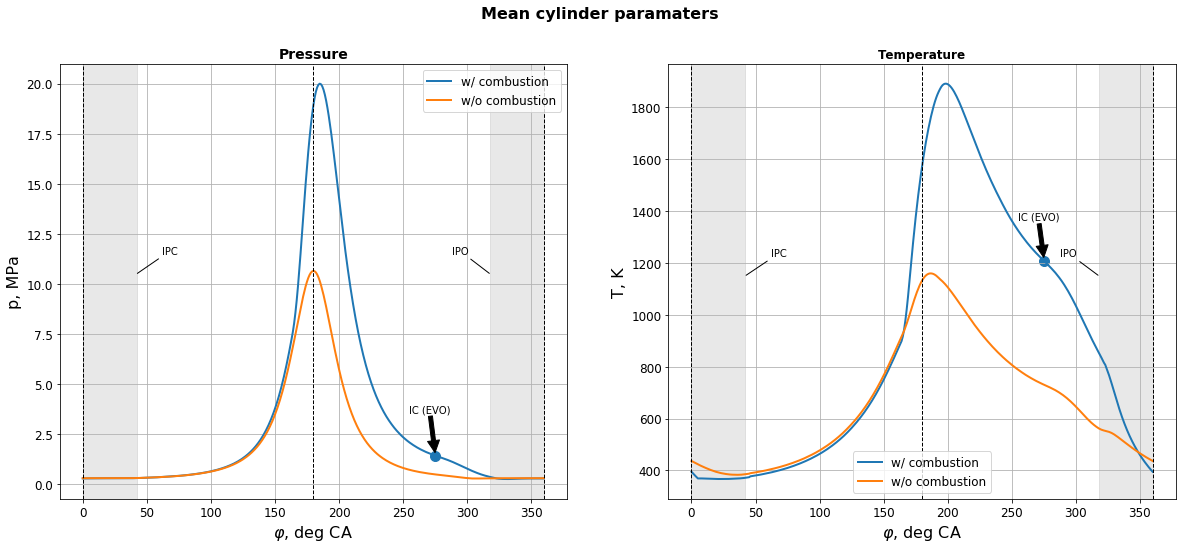

In [14]:
''' Mean cylinder parameters (all cycles) '''

#- Pressure
plt.figure(
    figsize = (xFigSize*2, yFigSize)#, dpi = 80, facecolor = 'w', edgecolor = 'k'
).suptitle(
    'Mean cylinder paramaters', fontweight = 'bold', fontsize = titleFontSize
)
plt.subplot(121).set_title(
    f'Pressure', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    p*1e-06,
    linewidth = linewidthHeavy,
    label = 'w/ combustion'
)
plt.plot(
    pWoCom*1e-06,
    linewidth = linewidthHeavy,
    label = 'w/o combustion'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.scatter(360 - EVO, p[360 - EVO]*1e-06, s = 100, marker = 'o')
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'p, MPa', fontsize = labelFontSize )

plt.axvline(x = 0,   color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvline(x = 180, color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvline(x = 360, color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvspan(0,         IPO, alpha = 0.18, color = 'grey')
plt.axvspan(360 - IPO, 360, alpha = 0.18, color = 'grey')
plt.annotate(
    'IPC', xy = (IPO, 10.5), xycoords = 'data',
    xytext = (IPO + 20, 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPO', xy = (360 - IPC, 10.5), xycoords = 'data',
    xytext = ((360 - IPC) - 30, 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IC (EVO)', xy = (360 - EVO, p[360 - EVO]*1.1e-06),
    xytext = (360 - EVO - 20, p[360 - EVO]*2.5e-06),
    arrowprops = dict(facecolor = 'black', shrinkB=1)
)


#- Temperature
plt.subplot(122).set_title(
    f'Temperature', fontweight = 'bold', fontsize = 12
)
plt.plot(
    T,
    linewidth = linewidthHeavy,
    label = 'w/ combustion'
)
plt.plot(
    TWoCom,
    linewidth = linewidthHeavy,
    label = 'w/o combustion'
)
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)
plt.scatter(360 - EVO, T[360 - EVO], s = 100, marker = 'o')
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'T, K', fontsize = labelFontSize )

plt.axvline(x = 0,   color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvline(x = 180, color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvline(x = 360, color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvspan(0,         IPO, alpha = 0.18, color = 'grey')
plt.axvspan(360 - IPO, 360, alpha = 0.18, color = 'grey')
plt.annotate(
    'IPC', xy = (IPO, 1150), xycoords = 'data',
    xytext = (IPO + 20, 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPO', xy = (360 - IPC, 1150), xycoords = 'data',
    xytext = ((360 - IPC) - 30, 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IC (EVO)', xy = (360 - EVO, T[360 - EVO]*1.01),
    xytext = (360 - EVO - 20, T[360 - EVO]*1.13),
    arrowprops = dict(facecolor = 'black', shrinkB=1)
)

<center>
    <b> Рисунок 1.5 </b> – Интегральные параметры внутри цилиндра (синей точкой обозначен момент открытия выпускного клапана - EVO)
</center>
<br>

Таким образом начальные условия в цилиндре:
- $p_{cyl0}$ = <!--{round(p[360 - EVO]*1e-06, 4)}}--> 1,442 (МПа), абсолютное давление
- $T_{cyl0}$ = <!--{T[360 - EVO]}}--> 1208,8 (K)
- $z_{cyl0}$ = <!--{round(abs(min(pistonCoord)), 5)}}--> 0,92549 (м), смещение цилиндра относительно НМТ

Для определения граничных условий на впуске и выпуске используем параметры во впускном и выпускном коллекторах соответственно, которые также были получены при идентификации двигателя (см. рисунок 1.6).

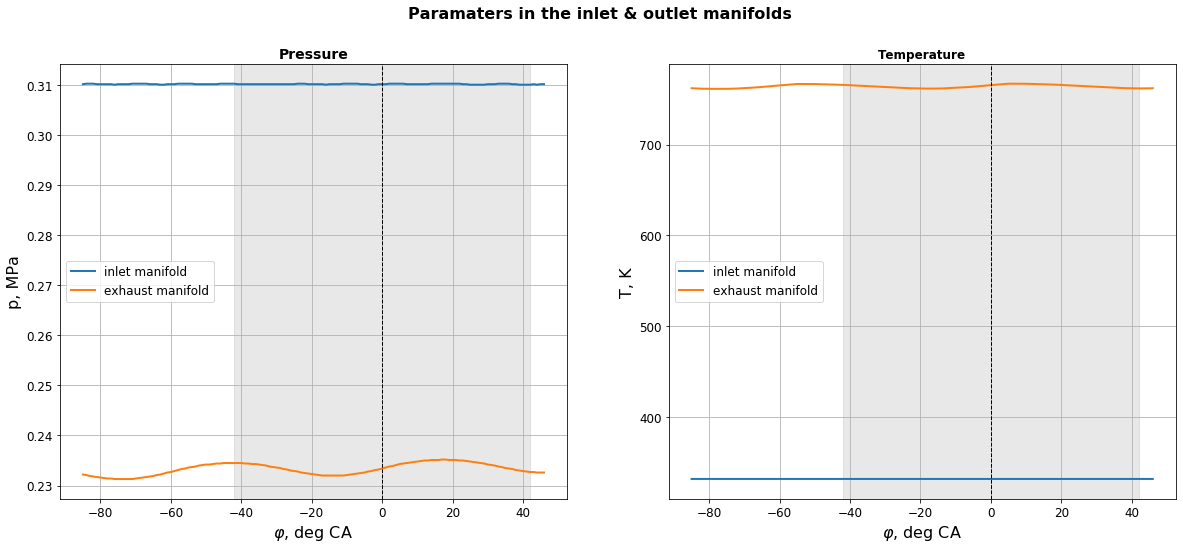

In [15]:
plt.figure(
    figsize = (xFigSize*2, yFigSize)#, dpi = 80, facecolor = 'w', edgecolor = 'k'
).suptitle(
    'Paramaters in the inlet & outlet manifolds', fontweight='bold', fontsize = titleFontSize
)

#- Pressure
plt.subplot(121).set_title(
    'Pressure', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(p_IP) - EVO),
    p_IP*1e-06,
    linewidth = linewidthHeavy,
    label = 'inlet manifold'
)
plt.plot(
    range(-EVO, len(p_exhPipe) - EVO),
    p_exhPipe*1e-06,
    linewidth = linewidthHeavy,
    label = 'exhaust manifold'
)
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'p, MPa', fontsize = labelFontSize )

plt.axvline(x = 0,   color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvspan(-IPO, IPO, alpha = 0.18, color = 'grey')


#- Temperature
plt.subplot(122).set_title(
    'Temperature', fontweight = 'bold', fontsize = 12
)
plt.plot(
    range(-EVO, len(T_IP) - EVO),
    T_IP,
    linewidth = linewidthHeavy,
    label = 'inlet manifold'
)
plt.plot(
    range(-EVO, len(T_exhPipe) - EVO),
    T_exhPipe,
    linewidth = linewidthHeavy,
    label = 'exhaust manifold'
)
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'T, K', fontsize = labelFontSize )

plt.axvline(x = 0,   color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvspan(-IPO, IPO, alpha = 0.18, color = 'grey')

<center>
    <b> Рисунок 1.6 </b> – Интегральные параметры во впускном и выпускном коллекторах соответственно
</center>
<br>

Так как во время рабочего процесса колебания давления и температуры в коллекторах незначительны, то для определения граничных условий принимаем средние значения этих параметров:
- Граничные условия на впуске:
    + ($p_{inlet}$ = <!--{{round(np.mean(p_IP)*1e-06, 4)}}--> 0.3102 (МПа), абсолютное давление)$^{1}$
    + $T_{inlet}$ = <!--{{round(np.mean(T_IP), 1)}}--> 332.0 (K)
- Граничные условия на выпуске:
    + $p_{outlet}$ = <!--{{round(np.mean(p_exhPipe)*1e-06, 4)}}--> 0.2333 (МПа), абсолютное давление
    + $T_{outlet}$ = <!--{{round(np.mean(T_exhPipe), 1)}}--> 769.3 (K)
---
$^{1}$ - давление на впуске при расчёте не использовалось и представлено как справочное значение

Для лучшей сходимости процесса решения предпочтительней задавать на входе в расчётную область скорость/расход. Параметры расхода для впуска также были определены при идентификации двигателя (см. рисунок 1.7).

Определяем максимальное значения расхода через впрыскивания. Принимаем, что 85% [3, т.II с.340] всей цикловой подачи составляет газовое топливо:

$$
    q_{цGas} = 0.85q_{ц} = 0.85 \bullet 115.64 = 98.294 \quad (г)
$$

Оцениваем время впрыскивания (четверть оборота коленчатого вала):

<!-- {{round(1/6/n *  45, 4)}} -->
$$
    t_{inj} \approx {1 \over 6n}45˚ = 0.0815 (с)
$$

Получаем максимальное значение относительного расхода ($A$ - сечение впускного отверстия диаметром 10 мм):

<!-- {{0.85*115.64 / (1/6/n * 45)/(pi * pow(0.01, 2)/4 * 2)}} -->
$$
    \rho U_{max} = {q_{цGas} \over t_{inj}A}
$$

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 8 Text yticklabel objects>)

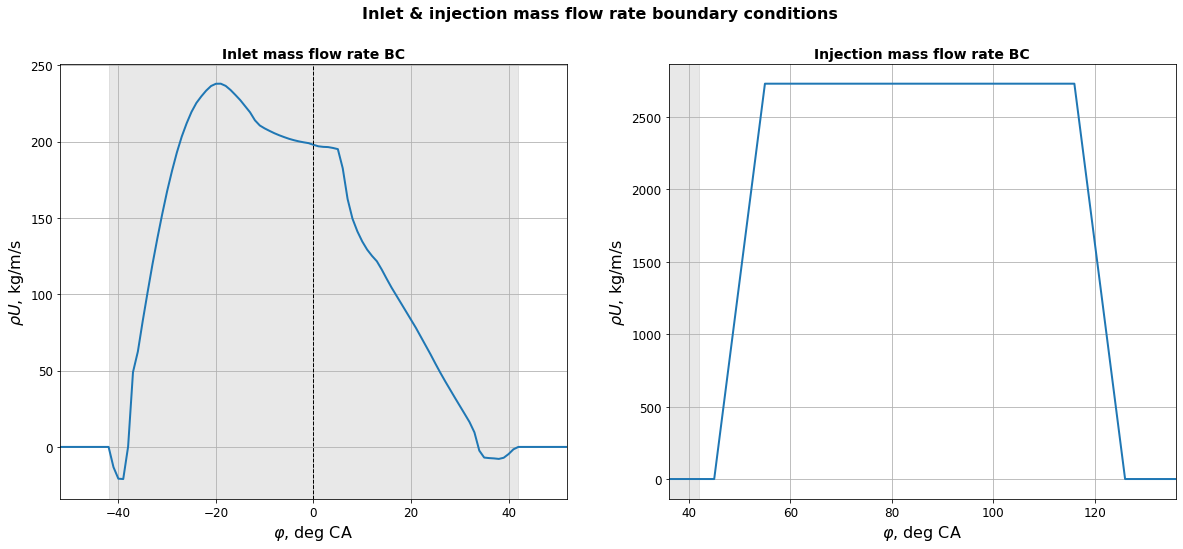

In [16]:
''' Inlet & injection mass flow rate '''

if massFlowRatePar == 'rhoU':
    yLabel = '$\\rho U$, kg/m/s'
    yG_inlet     = rhoU_inlet
    yG_injection = rhoU_injection

elif massFlowRatePar == 'G':
    yLabel = 'G, kg/s'
    yG_inlet     = G_inlet
    yG_injection = G_injection
else:
    exit('Error: massFlowRatePar variable is incorrect!')

plt.figure(
    figsize = (xFigSize*2, yFigSize)
).suptitle(
    'Inlet & injection mass flow rate boundary conditions', fontweight = 'bold', fontsize = titleFontSize
)

#- Inlet
plt.subplot(121).set_title(
    'Inlet mass flow rate BC', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(yG_inlet) - EVO),
    yG_inlet,
    linewidth = linewidthHeavy
    # label = 'inlet'
)
plt.xlim(-IPO - 10, IPO + 10)
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)
plt.grid( True );    # plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( yLabel, fontsize = labelFontSize )

plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvspan(-IPO, IPO, alpha = 0.18, color = 'grey')


#- Injection
plt.subplot(122).set_title(
    'Injection mass flow rate BC', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(yG_inlet) - EVO),
    yG_injection,
    linewidth = linewidthHeavy
    # label = 'injection'
)
plt.xlim(EVC - 10, EVC + injDuration + injCA2Max*2 + 10)
plt.grid( True );    # plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( yLabel, fontsize = labelFontSize )

plt.axvspan(-IPO, IPO, alpha = 0.18, color = 'grey')
plt.xticks(fontsize = ticksFontSize);    plt.yticks(fontsize = ticksFontSize)

<center>
    <b> Рисунок 1.7 </b> – Отнесённый к площади массовый расход через впускные окна (слева) и газовую форсунку (справа)
</center>
<br>

При идентификации были также определены и законы движения поршня и выпускного клапана (см. рисунок 1.8).

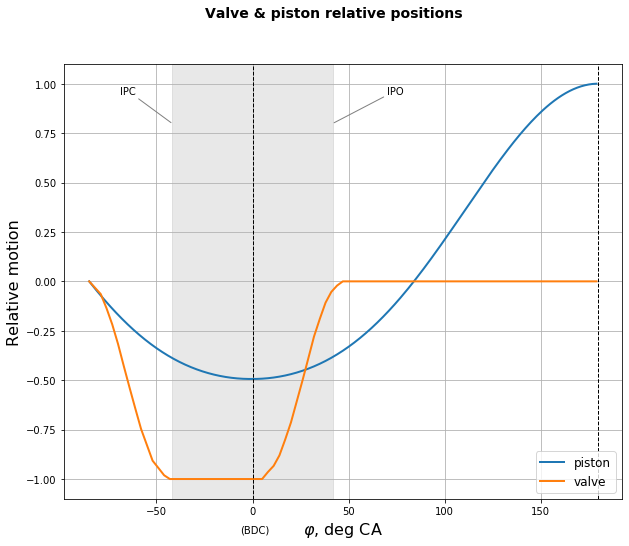

In [17]:
plt.figure(
    figsize = (xFigSize, yFigSize)
).suptitle(
    'Valve & piston relative positions', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, 180),
    pistonCoord
   /max(pistonCoord),
    linewidth = linewidthHeavy,
    label = 'piston'
)
plt.plot(
    range(-EVO, 180, valveCoordFrequency),
  - valveCoord
   /min(valveCoord),
    linewidth = linewidthHeavy,
    label = 'valve'
)
plt.annotate(
    '(BDC)', (1, 1),
    xytext = (EVO/(EVO + 180)*1.15, -0.06), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top'
)
plt.annotate(
    'IPC', xy = (-IPO, 0.8),  xycoords = 'data',
    xytext = (0.1, 0.95), textcoords = 'axes fraction',
    arrowprops = dict(arrowstyle = "-", color = "0.5", shrinkB = 1),
    horizontalalignment = 'left', verticalalignment = 'top'
)
plt.annotate(
    'IPO', xy =(IPO, 0.8), xycoords = 'data',
    xytext = (0.58, 0.95), textcoords = 'axes fraction',
    arrowprops = dict(arrowstyle = "-", color = "0.5", shrinkB = 1),
    horizontalalignment = 'left', verticalalignment = 'top'
)
plt.grid( True );    plt.legend( loc = 'lower right', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'Relative motion', fontsize = labelFontSize )

plt.axvspan(-IPC, IPO, alpha = 0.18, color = 'grey')
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvline(x = 180, color = 'black', linestyle = '--', linewidth = linewidthLight)

<center>
    <b> Рисунок 1.8 </b> – Относительный ход поршня и клапана (для поршня за нулевое положение принята НМТ)
</center>
<br>

Таким образом, схема граничных и начальных условий будет выглядеть следующим образом (см. рисунок 1.9):

<br>
<center>
     <img
        src="https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-BCScheme.png"
        alt="Figure 1"
        width="500" /* height="200" */
    />
    <b> Рисунок 1.9 </b> – Схема граничных и начальных условий
</center>
<br>

При горении природного газа большую часть отработавших газов составляет азот (до 70%) [3]. Однако, для упрощения расчётов именно азот и был принят в качестве отработавших газов.

# **2 Расчёт во FlowVision**
На основе чертежа из сервисной книги [4] была построена твердотельная модель геометри для проведения расчётов (см. рисунок 2.1). 

<br>
<center>
     <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-half.png"
        alt = "Figure 2.1"
        width = "350"
    />
    <b> Рисунок 2.1 </b> – Твердотельная модель расчётной области
</center>
<br>

Была упрощена геометрия межклапанной щели – убраны лабиринтные уплотнения (см. рисунок 2.2).

<br>
<center>
     <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/diffChannel.png"
        alt = "Figure 2.2"
        width = "500"
    />
    <b> Рисунок 2.2 </b> – Клапанная щель: действительная (A), упрощённая (B)
</center>
<br>

Также была упрощена и конструкция форсунки, которая была заменена цилиндром диаметром 8 мм.

## **2.1 Подготовительные расчёты**
Для определения параметров сетки и проверки адекватности получаемых результатов было решено провести серию расчётов на четверти расчётной области для экономии вычислительных ресурсов и уменьшения времени счёта.

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-quarter.png"
        alt = "Figure 2.3"
        width = "200"
    />
    <b> Рисунок 2.3 </b> – Твердотельная модель расчётной области для проведения подготовительных расчётов
</center>
<br>

При задании параметров проекта во FlowVision на этапе подготовительных расчётов на плоскостях сечения моделируемой области были использованы граничные условия симметрии. Подвижные тела (такие как клапан и поршень) - были заданы модификаторами, их закон движения известен (см. рисунок 1.8) и был задан был продифференцирован для получения закона движения в виде $U(t)$: во FlowVision задание закона движения подвижных частей возможно только через задание их соответствующих скоростей.

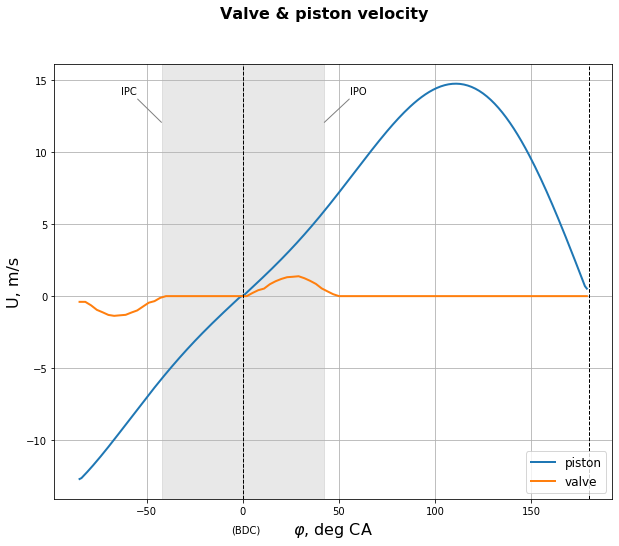

In [18]:
''' Valve & piston velocity '''

plt.figure(
    figsize = (xFigSize, yFigSize)
).suptitle(
    'Valve & piston velocity', fontweight = 'bold', fontsize = titleFontSize
)
plt.plot(
    range(-EVO, 180),
    pistonU,
    linewidth = linewidthHeavy,
    label = 'piston'
)
plt.plot(
    range(-EVO, 180, valveCoordFrequency),
    valveU,
    linewidth = linewidthHeavy,
    label = 'valve'
)
plt.annotate(
    '(BDC)', (1, 1),
    xytext = (EVO/(EVO + 180)*1.15, -0.06), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top'
)
plt.annotate(
    'IPC', xy = (-IPO, 12),  xycoords = 'data',
    xytext = (0.12, 0.95), textcoords = 'axes fraction',
    arrowprops = dict(arrowstyle = "-", color = "0.5", shrinkB = 1),
    horizontalalignment = 'left', verticalalignment = 'top'
)
plt.annotate(
    'IPO', xy =(IPO, 12), xycoords = 'data',
    xytext = (0.53, 0.95), textcoords = 'axes fraction',
    arrowprops = dict(arrowstyle = "-", color = "0.5", shrinkB = 1),
    horizontalalignment = 'left', verticalalignment = 'top'
)
plt.grid( True );    plt.legend( loc = 'lower right', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'U, m/s', fontsize = labelFontSize )

plt.axvspan(-IPC, IPO, alpha = 0.18, color = 'grey')
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = linewidthLight)
plt.axvline(x = 180, color = 'black', linestyle = '--', linewidth = linewidthLight)

<center>
    <b> Рисунок 2.3 </b> – Законы движения подвижных деталей
</center>
<br>

В ходе расчётов использовалась модель зазора, при использовании которой удалось уйти от прямого численного моделирования течения в клапанной щели.
Также была проведена серия расчётов при разных степенях адаптации сетки – 1, 2 и 3 (максимальное число ячеек <i>4875</i>, <i>23531</i> и <i>85099</i> соответственно) (см. рисунок 2.4).

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-mesh_maxRefinement1.png"
        alt = "Figure 2.4-1"
        width = "1000"
    />
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-mesh_maxRefinement2.png"
        alt = "Figure 2.4-2"
        width = "1000"
    />
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-mesh_maxRefinement3.png"
        alt = "Figure 2.4-3"
        width = "1000"
    />
    <b> Рисунок 2.4 </b> – Варианты расчётной сетки от минимальной (1) до максимальной степени адаптации (3) (максимальное число ячеек <i>4875</i>, <i>23531</i> и <i>85099</i> соответственно)
</center>
<br>

Для проведения валидации расчёта было проведено сравнение интегральных показателей в цилиндре с данными получеными в Дизель-РК. Достаточная сходимость по интегральным данным была достугнута уже даже на самой грубой сетке (см. рисунок 2.5).

In [ ]:
''' Get FlowVision cylinder data '''

def getCylFlowVisionData(caseName):

    #- Cylinder pressure
    p = pd.read_csv(
        f"MAN_BnW.fvres/{caseName}.fvres/cylP.glo",
        encoding = 'utf-8',
        delimiter = '\t'
    )

    #- Cylinder temperature
    T = pd.read_csv(
        f"MAN_BnW.fvres/{caseName}.fvres/cylT.glo",
        encoding = 'utf-8',
        delimiter = '\t'
    )

    return p, T

p_quarterRefinement1, T_quarterRefinement1 = getCylFlowVisionData('quarterMaxRefinement1_deltaT2CA')
p_quarterRefinement2, T_quarterRefinement2 = getCylFlowVisionData('quarterMaxRefinement2_deltaT025CA')
p_quarterRefinement3, T_quarterRefinement3 = getCylFlowVisionData('quarterMaxRefinement3_deltaT025CA')

Text(57, 1225, 'IPC')

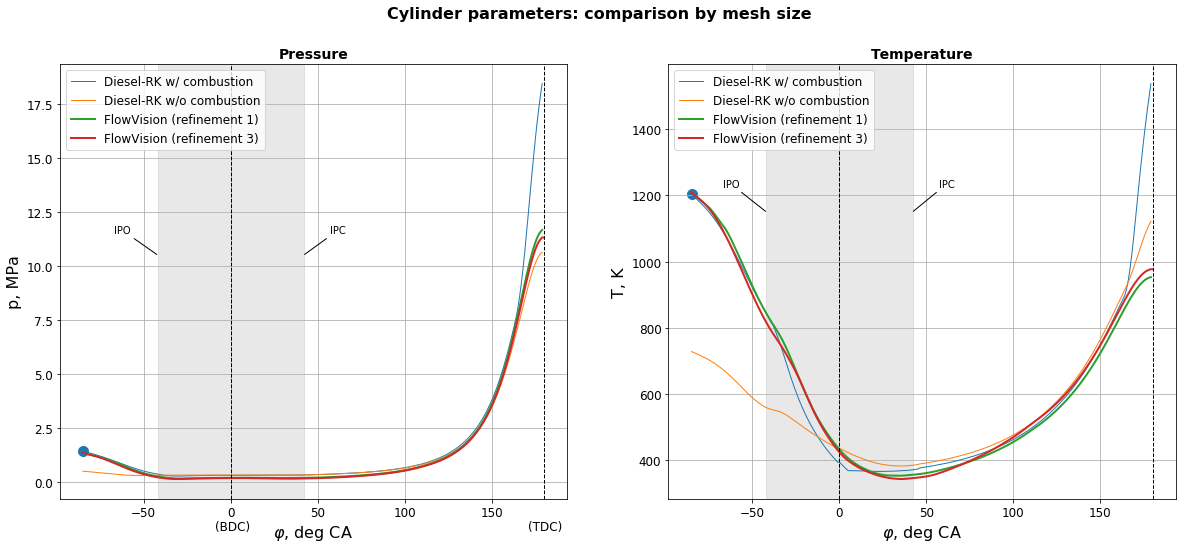

In [20]:
''' Integal paramaters in the cylinder '''

plt.figure(
    figsize = (xFigSize*2, yFigSize)
).suptitle(
    'Cylinder parameters: comparison by mesh size', fontweight='bold', fontsize = titleFontSize
)

#- Pressure
plt.subplot(121).set_title(
    f'Pressure', fontweight = 'bold', fontsize = subplotFontSize
)
plt.scatter(-EVO, p_DrkWCom[0]*1e-06, s = 100, marker='o')
plt.plot(
    range(-EVO, 180),
    p_DrkWCom*1e-06,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/ combustion'
)
plt.plot(
    range(-EVO, 180),
    p_DrkWoCom*1e-06,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/o combustion'
)
plt.plot(
    range(-EVO, len(p_quarterRefinement1['AverageByMass']) - EVO),
    p_quarterRefinement1['AverageByMass']*1e-06,
    linewidth = linewidthHeavy,
    label = 'FlowVision (refinement 1)'
)
# plt.plot(
#     range(-EVO, len(p_quarterRefinement2['AverageByMass']) - EVO),
#     p_quarterRefinement2['AverageByMass']*1e-06,
#     linewidth = linewidthHeavy,
#     label = 'FlowVision (refinement 2)'
# )
plt.plot(
    range(-EVO, len(p_quarterRefinement3['AverageByMass']) - EVO),
    p_quarterRefinement3['AverageByMass']*1e-06,
    linewidth = linewidthHeavy,
    label = 'FlowVision (refinement 3)'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA',fontsize = labelFontSize )
plt.ylabel( 'p, MPa', fontsize = labelFontSize )

plt.annotate(
    '(BDC)', (1, 1),
    xytext = (EVO/(EVO + 180)*1.17, -0.05), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    fontsize = legendFontSize
)
plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.annotate(
    '(TDC)', (1, 1),
    xytext = (0.99, -0.05), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    fontsize = legendFontSize
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
plt.annotate(
    'IPO', xy = (-IPO, 10.5), xycoords = 'data',
    xytext = (-(IPO + 25), 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPC', xy = (IPO, 10.5), xycoords = 'data',
    xytext = (IPO + 15, 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)


#- Temperature
plt.subplot(122).set_title(
    f'Temperature', fontweight = 'bold', fontsize = subplotFontSize
)
plt.scatter(-EVO, T_DrkWCom[0], s = 100, marker = 'o')
plt.plot(
    range(-EVO, 180),
    T_DrkWCom,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/ combustion'
)
plt.plot(
    range(-EVO, 180),
    T_DrkWoCom,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/o combustion'
)
plt.plot(
    range(-EVO, len(T_quarterRefinement1['AverageByMass']) - EVO),
    T_quarterRefinement1['AverageByMass'] + 273,
    linewidth = linewidthHeavy,
    label = 'FlowVision (refinement 1)'
)
# plt.plot(
#     range(-EVO, len(T_quarterRefinement2['AverageByMass']) - EVO),
#     T_quarterRefinement2['AverageByMass'] + 273,
#     linewidth = linewidthHeavy,
#     label = 'FlowVision (refinement 2)'
# )
plt.plot(
    range(-EVO, len(T_quarterRefinement3['AverageByMass']) - EVO),
    T_quarterRefinement3['AverageByMass'] + 273,
    linewidth = linewidthHeavy,
    label = 'FlowVision (refinement 3)'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'T, K', fontsize = labelFontSize )

plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
plt.annotate(
    'IPO', xy = (-IPO, 1150), xycoords = 'data',
    xytext = (-(IPO + 25), 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPC', xy = (IPO, 1150), xycoords = 'data',
    xytext = (IPO + 15, 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)

<center>
    <b> Рисунок 2.5 </b> – Сравнение интегральных параметров в цилиндре
</center>

Также было проведено сранение расхода на выходе (см. рисунок 2.6). Колебания расхода на начальном этапе выпуска вызваны не проявлением нестабильности расчёта, а колебательным процессом в выпускном канале – отражением волны от открытого конца трубы.

In [ ]:
''' Get FlowVision outlet mass flow rate data '''

def getGFlowVisionData(caseName):
    
    #- Outlet mass flow rate
    outlet = pd.read_csv(
        f"MAN_BnW.fvres/{caseName}.fvres/outletU.glo",
        encoding = 'utf-8',
        delimiter = '\t',
        na_values = 'NONE'
    )
    outlet['dG'] = outlet['MassFlowN'] - outlet['MassFlowP']

    return outlet

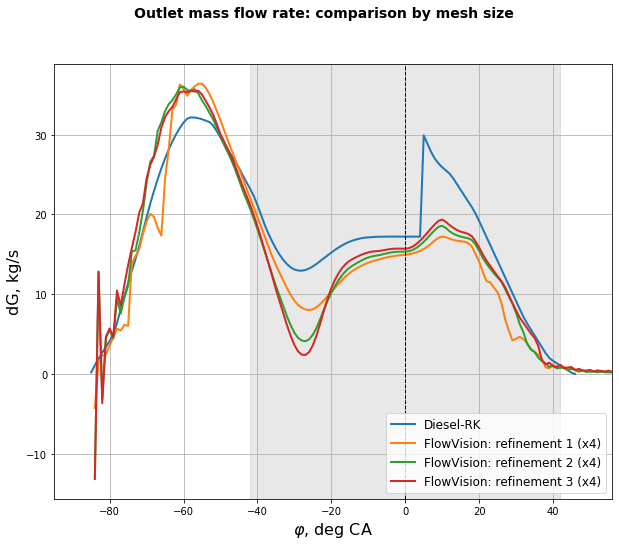

In [22]:
''' Parameters at the outlet comparison'''

plt.figure(
    figsize = (xFigSize, yFigSize)
).suptitle(
    'Outlet mass flow rate: comparison by mesh size', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(G_outlet) - EVO),
    G_outlet,
    linewidth = linewidthHeavy,
    label = 'Diesel-RK'
)
plt.plot(
    range(-EVO, 180),
    getGFlowVisionData('quarterMaxRefinement1_deltaT2CA')['dG']*4,
    linewidth = linewidthHeavy,
    label = 'FlowVision: refinement 1 (x4)'
)
plt.plot(
    range(-EVO, len(getGFlowVisionData('quarterMaxRefinement2_deltaT025CA')['dG']) - EVO),
    getGFlowVisionData('quarterMaxRefinement2_deltaT025CA')['dG']*4,
    linewidth = linewidthHeavy,
    label = 'FlowVision: refinement 2 (x4)'
)
plt.plot(
    range(-EVO, len(getGFlowVisionData('quarterMaxRefinement3_deltaT025CA')['dG']) - EVO),
    getGFlowVisionData('quarterMaxRefinement3_deltaT025CA')['dG']*4,
    linewidth = linewidthHeavy,
    label = 'FlowVision: refinement 3 (x4)'
)
plt.xlim(-EVO - 10, EVC + 10)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'dG, kg/s', fontsize = labelFontSize )

plt.axvspan(-IPC, IPO, alpha = 0.18, color = 'grey')
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = linewidthLight)

<center>
    <b> Рисунок 2.6 </b> – Сравнение расходов на выходе из расчётной области при разной степени адаптации сетки
</center>

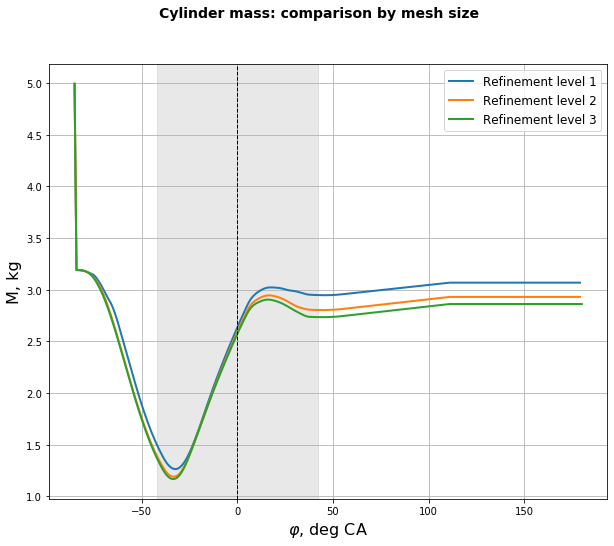

In [23]:
''' Cylinder mass '''

plt.figure(
    figsize = (xFigSize, yFigSize)
).suptitle(
    'Cylinder mass: comparison by mesh size', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(p_quarterRefinement1['Mass']) - EVO),
    p_quarterRefinement1['Mass']*4,
    linewidth = linewidthHeavy,
    label = 'Refinement level 1'
)
plt.plot(
    range(-EVO, len(p_quarterRefinement2['Mass']) - EVO),
    p_quarterRefinement2['Mass']*4,
    linewidth = linewidthHeavy,
    label = 'Refinement level 2'
)
plt.plot(
    range(-EVO, len(p_quarterRefinement3['Mass']) - EVO),
    p_quarterRefinement3['Mass']*4,
    linewidth = linewidthHeavy,
    label = 'Refinement level 3'
)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'M, kg', fontsize = labelFontSize )

plt.axvspan(-IPC, IPO, alpha = 0.18, color = 'grey')
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = linewidthLight)

<center>
    <b> Рисунок 2.7 </b> – Сравнение массы в цилидре при разной степени адаптации сетки
</center>

In [ ]:
''' Get FlowVision concentration data '''

def getAlphaFlowVisionData(caseName):
    
    alphaAir = pd.read_csv(
        f"MAN_BnW.fvres/{caseName}.fvres/cylAlphaAir.glo",
        encoding = 'utf-8',
        delimiter = '\t',
        na_values = 'NONE'
    )
    alphaExh = pd.read_csv(
        f"MAN_BnW.fvres/{caseName}.fvres/cylAlphaExh.glo",
        encoding = 'utf-8',
        delimiter = '\t',
        na_values = 'NONE'
    )
    alphaGas = pd.read_csv(
        f"MAN_BnW.fvres/{caseName}.fvres/cylAlphaGas.glo",
        encoding = 'utf-8',
        delimiter = '\t',
        na_values = 'NONE'
    )
    return alphaAir, alphaExh, alphaGas

alphaAir_quarterRefinement1, alphaExh_quarterRefinement1, alphaGas_quarterRefinement1 = getAlphaFlowVisionData('quarterMaxRefinement1_deltaT2CA')
alphaAir_quarterRefinement2, alphaExh_quarterRefinement2, alphaGas_quarterRefinement2 = getAlphaFlowVisionData('quarterMaxRefinement2_deltaT025CA')
alphaAir_quarterRefinement3, alphaExh_quarterRefinement3, alphaGas_quarterRefinement3 = getAlphaFlowVisionData('quarterMaxRefinement3_deltaT025CA')

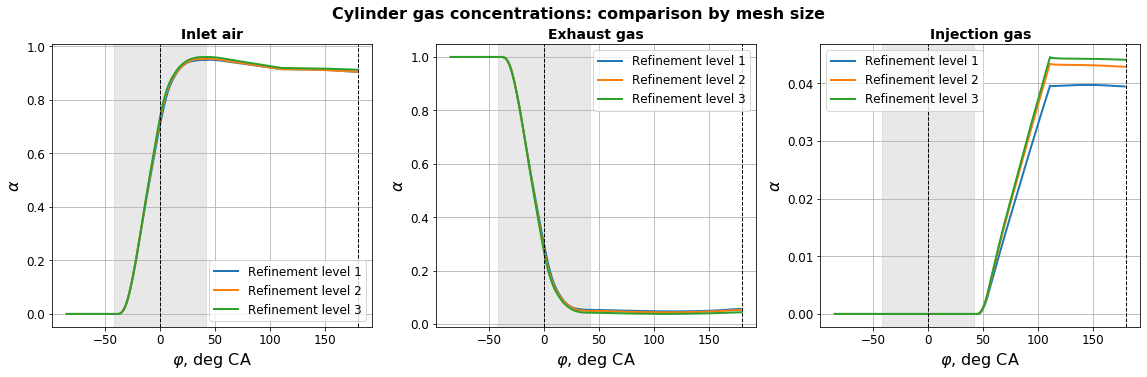

In [25]:
''' Integal concentration parameters in the cylinder '''

alphaAveragePar = 'Avg' # Avg \ AverageByMass

plt.figure(
    figsize = (xFigSize*3*0.65, yFigSize*0.65)
).suptitle(
    'Cylinder gas concentrations: comparison by mesh size', fontweight = 'bold', fontsize = titleFontSize
)

#- Inlet air
plt.subplot(131).set_title(
    'Inlet air', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(alphaAir_quarterRefinement1[alphaAveragePar]) - EVO),
    alphaAir_quarterRefinement1[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 1'
)
plt.plot(
    range(-EVO, len(alphaAir_quarterRefinement2[alphaAveragePar]) - EVO),
    alphaAir_quarterRefinement2[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 2'
)
plt.plot(
    range(-EVO, len(alphaAir_quarterRefinement3[alphaAveragePar]) - EVO),
    alphaAir_quarterRefinement3[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 3'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA',fontsize = labelFontSize )
plt.ylabel( '$\\alpha$', fontsize = labelFontSize )

plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
# plt.annotate(
#     'IPO', xy = (-IPO, 0.8), xycoords = 'data',
#     xytext = (-(IPO + 25), 0.85),
#     arrowprops = dict(arrowstyle = "-", shrinkB = 1)
# )
# plt.annotate(
#     'IPC', xy = (IPO, 0.8), xycoords = 'data',
#     xytext = (IPO + 15, 0.85),
#     arrowprops = dict(arrowstyle = "-", shrinkB = 1)
# )


#- Exhaust gas
plt.subplot(132).set_title(
    'Exhaust gas', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(alphaExh_quarterRefinement1[alphaAveragePar]) - EVO),
    alphaExh_quarterRefinement1[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 1'
)
plt.plot(
    range(-EVO, len(alphaExh_quarterRefinement2[alphaAveragePar]) - EVO),
    alphaExh_quarterRefinement2[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 2'
)
plt.plot(
    range(-EVO, len(alphaExh_quarterRefinement3[alphaAveragePar]) - EVO),
    alphaExh_quarterRefinement3[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 3'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA',fontsize = labelFontSize )
plt.ylabel( '$\\alpha$', fontsize = labelFontSize )

plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
# plt.annotate(
#     'IPO', xy = (-IPO, 0.8), xycoords = 'data',
#     xytext = (-(IPO + 25), 0.85),
#     arrowprops = dict(arrowstyle = "-", shrinkB = 1)
# )
# plt.annotate(
#     'IPC', xy = (IPO, 0.8), xycoords = 'data',
#     xytext = (IPO + 15, 0.85),
#     arrowprops = dict(arrowstyle = "-", shrinkB = 1)
# )


#- Injection gas
plt.subplot(133).set_title(
    'Injection gas', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(alphaGas_quarterRefinement1[alphaAveragePar]) - EVO),
    alphaGas_quarterRefinement1[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 1'
)
plt.plot(
    range(-EVO, len(alphaGas_quarterRefinement2[alphaAveragePar]) - EVO),
    alphaGas_quarterRefinement2[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 2'
)
plt.plot(
    range(-EVO, len(alphaGas_quarterRefinement3[alphaAveragePar]) - EVO),
    alphaGas_quarterRefinement3[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'Refinement level 3'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA',fontsize = labelFontSize )
plt.ylabel( '$\\alpha$', fontsize = labelFontSize )

plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
# plt.annotate(
#     'IPO', xy = (-IPO, 0.021), xycoords = 'data',
#     xytext = (-(IPO + 25), 0.025),
#     arrowprops = dict(arrowstyle = "-", shrinkB = 1)
# )
# plt.annotate(
#     'IPC', xy = (IPO, 0.021), xycoords = 'data',
#     xytext = (IPO + 15, 0.025),
#     arrowprops = dict(arrowstyle = "-", shrinkB = 1)
# )

<center>
    <b> Рисунок 2.8 </b> – Сравнение концентраций газов в цилиндре при разной степени адаптации сетки
</center>

Пример полученных результатов:

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-quarter_XYinjCutU&T.png"
        alt = "Figure 2.9"
        width = "500"
    />
    <b> Рисунок 2.9 </b> – Поперечное сечение поля температуры свежего заряда зоны впрыскивания природного газа
    <br>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-quarter_YZCut-U&alphaExh.png"
        alt = "Figure 2.10"
        width = "1000"
    />
    <b> Рисунок 2.10 </b> – Осевое сечение поля концентрации остаточных газов во время продувки (поршень в НМТ)
</center>
<br>

Стоит сказать, что использование граничных условий симметрии и моделирование четверти рабочего объёма цилиндра допустимо только для валидации (подготовительного этапа расчёта) так как:
- **течение газа в двигателях внутренного сгорания не является симметричным**
- струя впрыскиваемого газа "растекается" по ГУ симметрии (см. рисунок 2.11) - в действительности две встречных струи должны взаимодействовать между собой
- образуется вихрь перпендикулярный оси цилиндра лежащий в данном секторе (см. рисунки 2.12-2.13), в действительности должно быть как при моделировании полной расчётной области (см. рисунки 2.17-2.19) – один вихрь вокруг оси

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-quarter_YZCut-U&rho.png"
        alt = "Figure 2.11"
        width = "1000"
    />
    <b> Рисунок 2.11 </b> – Осевое сечение во время впрыскивания
    <br>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-quarter_XYinlet-U&T.png"
        alt = "Figure 2.12"
        width = "400"
    />
    <b> Рисунок 2.12 </b> – Поперечное сечение поля темпераратуры зоны впускных окон
    <br>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-quarter_XYinlet-U&alphaAir.png"
        alt = "Figure 2.13"
        width = "400"
    />
    <b> Рисунок 2.13 </b> – Поперечное сечение поля концентрации свежего заряда зоны впускных окон
</center>
<br>

## **2.2 Моделирование полной расчётной области**
Для полноценного расчёта использовалась геометрия представления на рисунке 2.1. Возможно было проводить расчёт для полвины расчётной области задая на плоскости симметрии периодические граничные условия. Однако во FlowVision присутствует не дающее это сделать ограничение: подвижное тело (в данном случае и поршень, и клапан) не должны пересекать поверхность периодического  граничного условия. В итоге, проводилось моделирование полной расчётной области.

In [ ]:
''' Get whole-domain case data '''

wholeDomainName = 'wholeDomain_deltaT025CA'

(
    p_wholeDomain,
    T_wholeDomain
) = getCylFlowVisionData(
    wholeDomainName 
)

(alphaAir_wholeDomain,
 alphaExh_wholeDomain,
 alphaGas_wholeDomain
) = getAlphaFlowVisionData(
    wholeDomainName
)

Text(57, 1225, 'IPC')

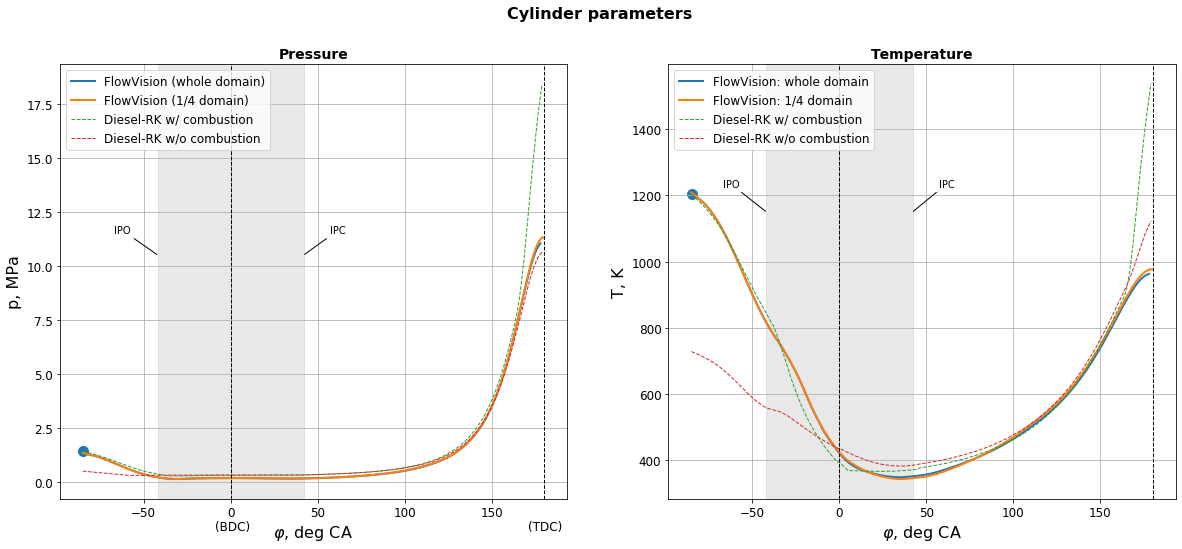

In [27]:
''' Integal paramaters in the cylinder '''

plt.figure(
    figsize = (xFigSize*2, yFigSize)
).suptitle(
    'Cylinder parameters', fontweight='bold', fontsize = titleFontSize
)

#- Pressure
plt.subplot(121).set_title(
    f'Pressure', fontweight = 'bold', fontsize = subplotFontSize
)
plt.scatter(-EVO, p_DrkWCom[0]*1e-06, s = 100, marker='o')
plt.plot(
    range(-EVO, len(p_wholeDomain['AverageByMass']) - EVO),
    p_wholeDomain['AverageByMass']*1e-06,
    linewidth = linewidthHeavy,
    label = 'FlowVision (whole domain)'
)
plt.plot(
    range(-EVO, len(p_quarterRefinement3['AverageByMass']) - EVO),
    p_quarterRefinement3['AverageByMass']*1e-06,
    linewidth = linewidthHeavy,
    label = 'FlowVision (1/4 domain)'
)
plt.plot(
    range(-EVO, 180),
    p_DrkWCom*1e-06,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/ combustion',
    linestyle = '--'
)
plt.plot(
    range(-EVO, 180),
    p_DrkWoCom*1e-06,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/o combustion',
    linestyle = '--'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA',fontsize = labelFontSize )
plt.ylabel( 'p, MPa', fontsize = labelFontSize )

plt.annotate(
    '(BDC)', (1, 1),
    xytext = (EVO/(EVO + 180)*1.17, -0.05), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    fontsize = legendFontSize
)
plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.annotate(
    '(TDC)', (1, 1),
    xytext = (0.99, -0.05), textcoords = 'axes fraction',
    horizontalalignment = 'right', verticalalignment = 'top',
    fontsize = legendFontSize
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
plt.annotate(
    'IPO', xy = (-IPO, 10.5), xycoords = 'data',
    xytext = (-(IPO + 25), 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPC', xy = (IPO, 10.5), xycoords = 'data',
    xytext = (IPO + 15, 11.5),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)


#- Temperature
plt.subplot(122).set_title(
    f'Temperature', fontweight = 'bold', fontsize = subplotFontSize
)
plt.scatter(-EVO, T_DrkWCom[0], s = 100, marker = 'o')
plt.plot(
    range(-EVO, len(T_wholeDomain['AverageByMass']) - EVO),
    T_wholeDomain['AverageByMass'] + 273,
    linewidth = linewidthHeavy,
    label = 'FlowVision: whole domain'
)
plt.plot(
    range(-EVO, len(T_quarterRefinement3['AverageByMass']) - EVO),
    T_quarterRefinement3['AverageByMass'] + 273,
    linewidth = linewidthHeavy,
    label = 'FlowVision: 1/4 domain'
)
plt.plot(
    range(-EVO, 180),
    T_DrkWCom,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/ combustion',
    linestyle = '--'
)
plt.plot(
    range(-EVO, 180),
    T_DrkWoCom,
    linewidth = linewidthLight,
    label = 'Diesel-RK w/o combustion',
    linestyle = '--'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'T, K', fontsize = labelFontSize )

plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
plt.annotate(
    'IPO', xy = (-IPO, 1150), xycoords = 'data',
    xytext = (-(IPO + 25), 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPC', xy = (IPO, 1150), xycoords = 'data',
    xytext = (IPO + 15, 1225),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)

In [28]:
''' Gas exchange parameters '''

molarMassAir = 29 # air molar mass
molarMassExh = 24 # exhaust gas molar mass

# Gas masses 
# ~~~~~~~~~~
#- Inlet air mass
mInletAir = np.trapz(G_inlet, dx = 1/6/n)

#- Air mass in the cylinder at the start of the compression cycle
mAir = (
    alphaAir_wholeDomain['AverageByMass'][EVO + EVC] # air concentration
   *alphaAir_wholeDomain['Mass'][EVO + EVC] # mass of all gases in the cylinder
)

#- Exhaust gas mass in the cylinder at the start of the compression cycle
mExh = (
    alphaExh_wholeDomain['AverageByMass'][EVO + EVC] # exhaust gas concentration
   *alphaExh_wholeDomain['Mass'][EVO + EVC] # mass of all gases in the cylinder
)


# Gas exchange parameters
# ~~~~~~~~~~~~~~~~~~~~~~~
#- Filling ratio
eta_v = (
    mAir*287*np.mean(T_IP)
   /np.mean(p_IP)
   /alphaAir_wholeDomain['Vol'][EVO] # V_h
)

#- Exhaust ratio
gamma_r = (
    mExh/molarMassExh
   /(mAir/molarMassAir)
)

#- Scavenging ratio
phi_sc = (
    mInletAir
   /mAir
)

# print(f"""
#    Filling ratio is {round(eta_v, 4)} (when Diesel-RK is 0.85852), error: {round(100*abs(eta_v - 0.85852)/0.85852, 2)}%
#    Exhaust ratio is {round(gamma_r, 4)} (when Diesel-RK is 0.04959), error: {round(100*abs(gamma_r - 0.04959)/gamma_r, 2)}%
# Scavenging ratio is {round(phi_sc, 4)} (when Diesel-RK is 1.2970), error: {round(100*abs(phi_sc - 1.2970)/phi_sc, 2)}%""")

<center>
    <b> Рисунок 2.14 </b> – Интегральные параметры в цилиндре
</center>

Также проведём сравнение коэффициентов параметров газообмена с Дизель-РК:
- Коэффициент наполнения [5,с. 60]:

$$
    \eta_v = {m_{1ц} \over \rho_{inlet}V_h } = {m_{1ц}R_{air}T_{inlet} \over p_{inlet}V_h } = 0.6842,
$$

где $m_{1ц}$ - количество свежего заряда в цилиндре двигателя в начале сжатия, кг; $R_{air}$ ≈ 287 - удельная газовая постоянная воздуха, Дж/кг/К; $V_h$ - рабочий объём цилиндра, куб.м.

Коэффициент наполнения определенный Дизель-РК: 0,85852. Погрешность при сравнении с результатом полученным FlowVision 20,3 %.
 
- Коэффициент остаточных газов [5,с. 61]:

$$
    \gamma = {M_r \over M_{1ц}} = 0.0603,
$$

где $M_r$ - количество остаточных газов в цилиндре двигателя в начале сжатия, моль; $M_r$ - количество свежего заряда в цилиндре двигателя в начале сжатия, моль;

Коэффициент остаточных газов определенный Дизель-РК: 0,04959. Погрешность при сравнении с результатом полученным FlowVision 17,81 %.

- Коэффициент продувки [5,с. 62]:

$$
    \varphi = {m_{inlet} \over m_{1ц}} = 1.546,
$$

где $m_{inlet}$ - количество вохдуха поступившего в цилиндр (определено с интегрированием кривой расхода (см. рисунок 1.7)), кг

Коэффициент остаточных газов определенный Дизель-РК: 1,2970. Погрешность при сравнении с результатом полученным FlowVision 16,11 %.

При сравнении коэффициентов газообмена с Дизель-РК стоит сказать, что в основе данного программного комплекса лежит термодинамическая модель, которая определяет приближённые параметры ДВС. Также некоторая погрешность между полученными значениями могла быть внесена при обработке данных из FlowVision.

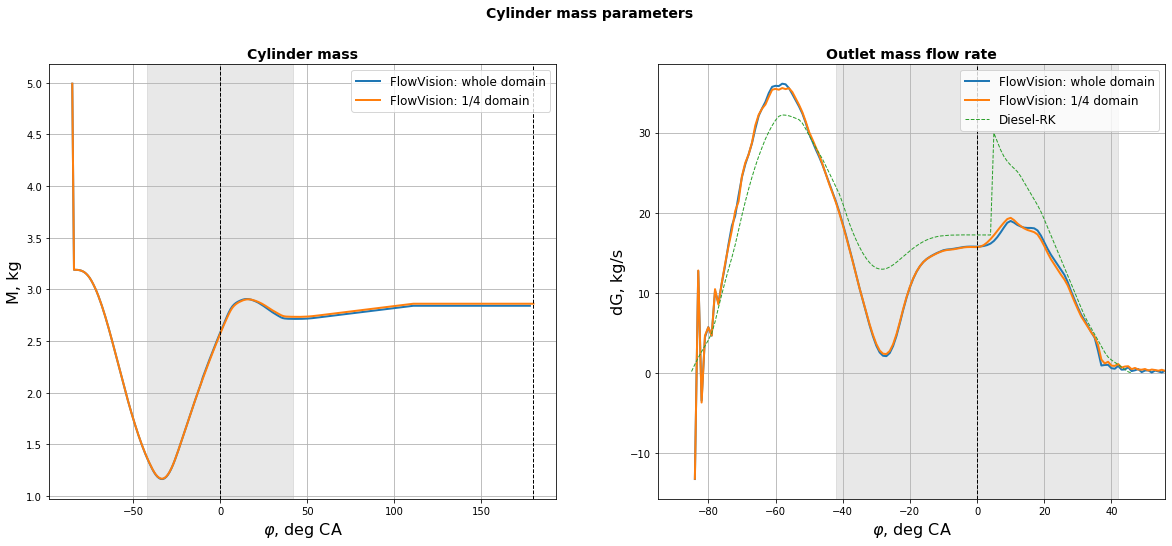

In [29]:
''' Parameters at the outlet '''

plt.figure(
    figsize = (xFigSize*2, yFigSize)
).suptitle(
    'Cylinder mass parameters', fontweight = 'bold', fontsize = subplotFontSize
)

#- Cylinder mass
plt.subplot(121).set_title(
    'Cylinder mass', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(p_wholeDomain['Mass']) - EVO),
    p_wholeDomain['Mass'],
    linewidth = linewidthHeavy,
    label = 'FlowVision: whole domain'
)
plt.plot(
    range(-EVO, len(p_quarterRefinement3['Mass']) - EVO),
    p_quarterRefinement3['Mass']*4,
    linewidth = linewidthHeavy,
    label = 'FlowVision: 1/4 domain'
)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'M, kg', fontsize = labelFontSize )

plt.axvspan(-IPC, IPO, alpha = 0.18, color = 'grey')
plt.axvline(
    x = 0,
    color = 'black',
    linestyle = '--',
    linewidth = linewidthLight
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)

#- Outlet mass flow rate 
plt.subplot(122).set_title(
    'Outlet mass flow rate', fontweight = 'bold', fontsize = subplotFontSize
)
plt.plot(
    range(-EVO, len(getGFlowVisionData(wholeDomainName)['dG']) - EVO),
    getGFlowVisionData(wholeDomainName)['dG'],
    linewidth = linewidthHeavy,
    label = 'FlowVision: whole domain'
)
plt.plot(
    range(-EVO, len(getGFlowVisionData('quarterMaxRefinement3_deltaT025CA')['dG']) - EVO),
    getGFlowVisionData('quarterMaxRefinement3_deltaT025CA')['dG']*4,
    linewidth = linewidthHeavy,
    label = 'FlowVision: 1/4 domain'
)
plt.plot(
    range(-EVO, len(G_outlet) - EVO),
    G_outlet,
    linewidth = linewidthLight,
    label = 'Diesel-RK',
    linestyle = '--'
)
plt.xlim(-EVO - 10, EVC + 10)
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA', fontsize = labelFontSize )
plt.ylabel( 'dG, kg/s', fontsize = labelFontSize )

plt.axvspan(-IPC, IPO, alpha = 0.18, color = 'grey')
plt.axvline(x = 0, color = 'black', linestyle = '--', linewidth = linewidthLight)

<center>
    <b> Рисунок 2.15 </b> – Расход на выходе из расчётной области
</center>

Text(52, 0.75, 'IPC')

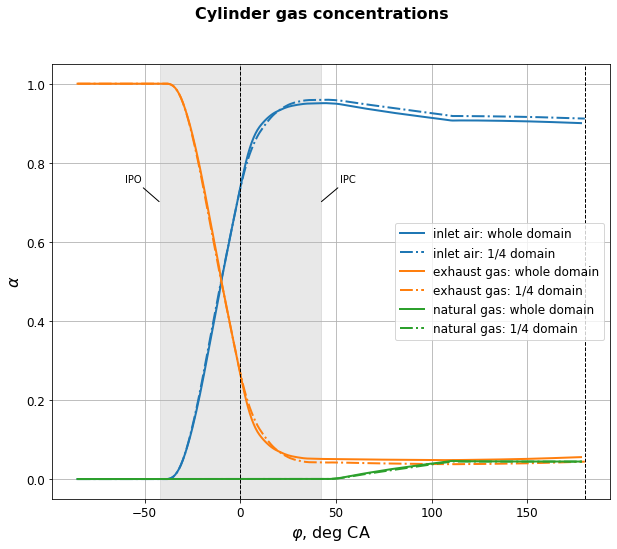

In [30]:
plt.figure(
    figsize = (xFigSize, yFigSize)
).suptitle(
    'Cylinder gas concentrations', fontweight = 'bold', fontsize = titleFontSize
)
plt.plot(
    range(-EVO, len(alphaAir_wholeDomain[alphaAveragePar]) - EVO),
    alphaAir_wholeDomain[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'inlet air: whole domain',
    color = 'C0'
)
plt.plot(
    range(-EVO, len(alphaAir_quarterRefinement3[alphaAveragePar]) - EVO),
    alphaAir_quarterRefinement3[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'inlet air: 1/4 domain',
    linestyle = '-.',
    color = 'C0'
)
plt.plot(
    range(-EVO, len(alphaExh_wholeDomain[alphaAveragePar]) - EVO),
    alphaExh_wholeDomain[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'exhaust gas: whole domain',
    color = 'C1'
)
plt.plot(
    range(-EVO, len(alphaExh_quarterRefinement3[alphaAveragePar]) - EVO),
    alphaExh_quarterRefinement3[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'exhaust gas: 1/4 domain',
    linestyle = '-.',
    color = 'C1'
)
plt.plot(
    range(-EVO, len(alphaGas_wholeDomain[alphaAveragePar]) - EVO),
    alphaGas_wholeDomain[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'natural gas: whole domain',
    color = 'C2'
)
plt.plot(
    range(-EVO, len(alphaGas_quarterRefinement3[alphaAveragePar]) - EVO),
    alphaGas_quarterRefinement3[alphaAveragePar],
    linewidth = linewidthHeavy,
    label = 'natural gas: 1/4 domain',
    linestyle = '-.',
    color = 'C2'
)
plt.xticks( fontsize = ticksFontSize );    plt.yticks( fontsize = ticksFontSize )
plt.grid( True );    plt.legend( loc = 'best', fontsize = legendFontSize )
plt.xlabel( '$\\varphi$, deg CA',fontsize = labelFontSize )
plt.ylabel( '$\\alpha$', fontsize = labelFontSize )

plt.axvline(
    x = 0,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvline(
    x = 180,
    linewidth = 1,
    color = 'black',
    linestyle = '--'
)
plt.axvspan(-IPO, IPC, alpha=0.18, color='grey')
plt.annotate(
    'IPO', xy = (-IPO, 0.7), xycoords = 'data',
    xytext = (-(IPO + 18), 0.75),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)
plt.annotate(
    'IPC', xy = (IPO, 0.7), xycoords = 'data',
    xytext = (IPO + 10, 0.75),
    arrowprops = dict(arrowstyle = "-", shrinkB = 1)
)

<center>
    <b> Рисунок 2.16 </b> – Концентрации газов в цилиндре
</center>
<br>

<br>

При сравнении интегральных параметров для 1/4 и полной расчётной области (см. рисунки 2.14-2.16) не наблюдалось существенных отклонений. Таким образом, использование полученного на этапе подготовительных расчётов (см. главу 2.1) разрешения сетки при проведении моделирования уже полной расчётной области, не влияет на результаты моделировния. Данное разрешение расчётной сетки и было использовано далее.

Примеры полученных результатов:

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-full_XYinlet-U&alphaExh.png"
        alt = "Figure 2.17"
        width = "600"
    />
    <b> Рисунок 2.17 </b> – Поперечное сечение поля концентрации остаточных газов зоны впускных окон
    <br>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-full_XYinlet-U&T.png"
        alt = "Figure 2.18"
        width = "600"
    />
    <b> Рисунок 2.18 </b> – Поперечное сечение поля температуры зоны впускных окон
    <br>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-full_XYinlet-U&p.png"
        alt = "Figure 2.19"
        width = "600"
    />
    <b> Рисунок 2.19 </b> – Поперечное сечение поля давлений зоны впускных окон
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-full_YZCut-U&alphaExh.png"
        alt = "Figure 2.20"
        width = "1000"
    />
    <b> Рисунок 2.20 </b> – Осевое сечение поля концентрации остаточных газов во время продувки (поршень в НМТ)
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-full_YZCut-U&T.png"
        alt = "Figure 2.21"
        width = "1000"
    />
    <b> Рисунок 2.21 </b> – Осевое сечение поля температуры во время продувки (поршень в НМТ)
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/movies/FlowVision/Man_BnW-whole_U&alphaGas.gif"
        alt = "Figure 2.22"
        width = "1000"
    />
    <b> Рисунок 2.22 </b> - Визуазация концетраций природного газа
</center>
<br>

При моделировании полной расчётной области удалось получить характерный для двигателей с впуском через окна вихрь (см. рисунки 2.17 - 2.19, 2.22), ось вращения которого совпадала с осью симметрии цилиндра.

С точки возможного моделировния сгорания желательно знать зону с наибольшей концентрацией основной дозы доплива (в данном случае природного газа) для подачи именно в эту область запальной струи топлива (pilot-injection). В данном случае наибольшая концентрация основной дозы топлива находится в камере сгорания поршня (см. рисунок 2.23).

<br>
<center>
    <img
        src = "https://github.com/StasF1/dualFuelEngine/wiki/src/images/FlowVision/MAN_BnW-full_YZCut-alphaAirExhGas.png"
        alt = "Figure 2.23"
        width = "5000"
    />
    <b> Рисунок 2.23 </b> - Поля концентраций газов в цилиндре на момент впрыскивыния запальной дозы топлива (концентрация свежего заряда, остаточных газов и основной дозы топлива соответственно)
</center>
<br>

# **ВЫВОДЫ**
Был изучен процесс сжатия малооборотного битопливного двухтаткого двигателя с помощью методов CFD-моделирования в программном комплексе FlowVision. Получены поля скоростей, термодинамических параметров и концентраций газов в цилиндре (тажке определены и интегральные значения данных параметров). При сравнении данных полученных с использовнием термодинамической модели и результатов CFD-моделирования противоречий не наблюдалось. Проведено сравнение интегральных параметров для 1/4 и полной расчётной области, между которыми не наблюдалось существенных отклонений. Таким образом, использование полученного ранее разрешения расчётной сетки (для четверти) при проведении моделировния полной расчётной было целесообразно с точки зрения экономии вычислительных ресурсов/расчётного времени для проведения аналдиза на сеточную сходимость. Определена зона (с наибольшей концентрацией основной дозы топлива) для возможной подачи в неё основной дозы топлива с точки зрение обеспечения более полного горения.

# **СПИСОК ИСПОЛЬЗОВАННЫХ ИСТОЧНИКОВ**
1. Nylund, Ingemar, and Ott, Marcel. “Development of a Dual Fuel technology for slow-speed engines.” International on combustion engines, CIMAC Congress 2013, Shanghai, Paper No.: 284
1. Diesel-RK is engine simulation software. URL https://diesel-rk.bmstu.ru/Eng/index.php (дата обращения: 04.03.2020)
1. Kuiken, Kees, et al. Diesel Engines: for Ship Propulsion and Power Plants: from 0 to 100,000 KW. Target Global Energy Training, 2008.
1. MAN B&W S70ME-C8. 5-TII Project Guide Electronically Controlled Two-stroke Engines - MAN Diesel, 2014
1. Двигатели внутреннего сгорания: Теория поршневых и комбинированных двиателей Д.Н. Вырубов, Н.А. Иващенко, В.И. Ивин и др.; Под ред. А.С. Орлина, М.Г. Круглова. – 4-е изд., перераб и доп. – М.: Машиностроения, 1983. – 372 с., ил.

# <center><b> Приложение А </b><center>
<center> Интегральные параметры двигателя полученные в ПК Дизель-РК </center>

<br>

```
   ----------------- МОЩНОСТНЫЕ И ЭФФЕКТИВНЫЕ ПОКАЗАТЕЛИ --------------- 
   92.000     - n        - Частота вращения коленчатого вала, [1/мин]              
   19559.     - Ne       - Mощность, [кВт]                                         
   19.730     - Pe       - Cреднее эффективное давление, [бар]                     
  2030326     - Me       - Крутящий момент, [Нм]                                   
   115.64     - qc       - Цикловая подача топлива, [г]                            
  0.19582     - be       - Удельный эффект. расход топлива, [кг/(кBт*ч)]           
  0.20564     - be_ISO   - Удельный эффект. расх. топлива по ISO,[кг/(кBт*ч)]      
  0.43258     - Eta_e    - Эффективный KПД                                         
   20.765     - Pi       - Cреднее индикаторное давление, [бар]                    
  0.45527     - Eta_i    - Индикаторный KПД                                        
   8.5867     - Sp       - Средняя скорость поршня, [м/с]                          
   1.0349     - Pтр      - Давление трения, [бар]                (Intern.Exp)   
  0.95016     - Eta_mex  - Mеханический KПД                                        
 
   --------------------- ПАРАМЕТРЫ ОКРУЖАЩЕЙ СРЕДЫ --------------------- 
   1.0000     - Po_sea   - Статическое давление на уровне моря, [бар]              
   288.00     - To_sea   - Статическая температура на уровне моря, [К]             
   0.0000     - Н_ур.мор - Высота над уровнем моря, [км]                           
   0.0000     - W_полета - Скорость полета, [км/час]                               
   1.0000     - Po       - Стат. давление окруж. среды в текущ. услов.,[бар]       
   288.00     - To       - Стат. температ. окруж. среды в текущ. услов.,[К]        
   1.0000     - Ро*      - Давление заторм. потока, [бар]                          
   288.00     - То*      - Температура заторможенного потока, [К]                  
   1.0400     - Pо_т     - Статическое давление за турбиной, [бар]                 
  0.97000     - Ро_вх*   - Давление заторм. потока за фильтром, [бар]              
 
   ------------------------ НАДДУВ И ГAЗOOБMEH ------------------------- 
   3.1025     - Pк       - Давление перед впускным коллектором, [бар]              
   324.04     - Tк       - Tемпература перед впускным коллектором, [K]             
   36.813     - Gair     - Pасход воздуха (+EGR) через цилиндры двиг.,[кг/с]       
  0.72586     - КПД_тк   - KПД агрегата наддува                                    
   2.3299     - Pt*      - Среднее давление перед турбиной, [бар]                  
   763.95     - Tt*      - Cредняя температура перед турбиной, [K]                 
   37.582     - Ggas     - Pасход O.Г. через цилиндры двиг., [кг/с]                
   2.3875     - Alfa_sum - Kоэфф. избытка воздуха суммарный                        
  0.85852     - Eta_v    - Kоэффициент наполнения                                  
  0.04959     - Gamma_r  - Kоэффициент остаточных газов                            
   1.2970     - Fi       - Kоэффициент продувки                                    
  0.54043     - G_забр.% - % заброса O.Г. во впускной коллектор                    
  0.04987     - G_утеч.% - % утечек через поршневые кольца                         
 
   ------------------------ BПУCKHOЙ KOЛЛEKTOP ------------------------- 
   3.1022     - Ps       - Среднее давление во впуск. коллект., [бар]              
   331.98     - Ts       - Средн. температ. во впуск. коллект., [K]                
   2.2973     - Ws       - Средняя скорость воздуха, [м/с]                         
   331.99     - Tws      - Cредняя температура стенки вп. колл., [K]               
   239.33     - Alfa_ws  - Kоэфф. теплоотдачи во вп. колл., [Bт/(м2*K)]            
   85.027     - Alfa_wsc - Kоэфф. теплоотд. в клап.канале, [Bт/(м2*K)]             
 
   ------------------------ BЫПУCKHOЙ KOЛЛEKTOP ------------------------ 
   2.3299     - Pr       - Среднее статическое давление O.Г., [бар]                
   763.95     - Tr       - Cредняя статическая температура O.Г., [K]               
   3.5081     - Wr       - Cредняя скорость газа, [м/с]                            
   16.019     - Sh       - Число Струхаля: Sh=a*Tau/L (д.б. Sh > 8)                
   613.72     - Twr      - Cредняя температура стенки вып. колл., [K]              
   90.000     - Alfa_wr  - Kоэфф. теплоотдачи в вып. колл., [Bт/(м2*K)]            
   231.09     - Alfa_wcr - Kоэфф. теплоотд. в клап.канале, [Bт/(м2*K)]             
   484.68     - MF_горла - Сумм. эфф. сечение горла клап. каналов, [см2]           
Оцен. разм. клап.: Кол=1 Dv=325.5 Dt=290.3 Ds=84.6 Lv= 67.3 Lv_max= 81.4 мм
 
   ------------------------------- CГOPAHИE ---------------------------- 
   1.8417     - Alfa     - Kоэффициент избытка воздуха при сгорании                
   199.94     - Pz       - Mаксимальное давление цикла, [бар]                      
   1890.7     - Tz       - Mаксимальная температура цикла, [K]                     
   5.0000     - Fi_pz    - Угол максимального давления, [град. за BMT.]            
   18.000     - Fi_tz    - Угол максимальн. температуры,[град. за BMT.]            
   7.5973     - dP/dFi   - Maкс. скор. нарастания давл., [бар/град]                
  0.00692     - Ring_Intn- Интенс. детонации / звук. воздейств., [MВт/м2]          
   779452     - F_max    - Макс. усилие на поршне от газовых сил, [кг]             
  Впрыск:    Common Rail                                                 
   1830.0     - P_впр.max- Mакс. давление перед соплами распылит., [бар]           
   1342.4     - P_впр.ср - Среднее давление впрыска всей порции топл., [бар]       
   29.454     - d_32     - Cредний диаметр капель, [мкм]                           
   17.000     - Teta_оп  - Oпережение впрыска / зажигания,[град.до BMT]            
   30.442     - Fi_впр   - Продолжительность топливоподачи, [град]                 
  0.31174     - Teta_здр - Период задержки воспламен. в цилиндре,[град]            
              -   ...    - расчет модифицированным методом Толстова:   0.3
   16.688     - SOC      - Начало сгорания, [град.до ВМТ] (Start Of Comb)          
  0.33468E-06 - Sig_и_здр- Доля топлива, испаривш. за период задержки              
   78.400     - Fi_горeн - Продолжительность сгорания, [град.п.к.в.]               
                           Phi_z 5%=  4.8;  Phi_z 50%= 21.6;  Phi_z 95%= 51.0
   6.7400     - H_вмт    - Вихревое число (отношение) в КС в ВМТ                   
   5.7210     - H_нмт    - Вихревое число в цилиндре в начале сжатия               
   14.555     - W_swirl  - Макс. скорость вихря [m/c] в КС на радиусе R= 151    
 
   ---------------------- ЭКОЛОГИЧЕСКИЕ ПОKАЗАТЕЛИ --------------------- 
   15.314     - Hartridge- Эмиссия дыма по шкале Хартриджа                         
   1.5920     - Bosch    - Эмиссия дыма по шкале Бош                               
  0.39096     - Kд       - Натур. показат. ослаблен. светов. потока,[1/m]          
  0.43495     - PM       - Эмиссия твердых частиц [г/(кВт*ч)]                      
   630.96     - CO2      - Эмиссия диоксида углерода, [г/(кВт*ч)]                  
   1.1601     - NO       - Эмиссия NOx привед. к NO, [г/(кВт*ч)]  (Zeldovich)   
   1.6156     - SE       - Комплекс суммарной эмиссии NOx и PM                     
  0.00783     - SO2      - Эмиссия SO2, [г/кВтч]                                   
 
   -------------------- BHУTPИЦИЛИHДPOBЫE ПAPAMETPЫ -------------------- 
   3.2511     - Pa       - Давление начала сжатия, [бар]                           
   377.12     - Ta       - Tемпература начала сжатия, [K]                          
   118.56     - Pc       - Давление конца сжатия, [бар]                            
   1002.6     - Tc       - Tемпература конца сжатия, [K]                           
   14.421     - Pb       - Давление начала выпуска, [бар]                          
   1208.8     - Tb       - Tемпература начала выпуска, [K]                         
 
   ----------------- ПАРАМЕТРЫ ТЕПЛООБМЕНА ЦИЛИНДРА -------------------- 
   1317.1     - T_ср     - Средняя эквивалентная температура цикла, [K]            
   503.66     - Alfa_w   - Cр. коэфф. теплоотд. от газа к стен,[Bт/м2/K]           
   620.00     - Tw_поршн - Cредн. температура огневого днища поршня, [K]           
   600.00     - Tw_втулк - Cредн. температ. огневой поверхн. втулки,[K]            
   600.00     - Tw_крышк - Cредн. температ. огневой поверхн. крышки,[K]            
   388.39     - Tw_охл   - Cредн. температура со стороны охлаждения                
                   крыш    крышки цилиндра, [K]                                    
   404.97     - Tкип.    - Температ.кипения в сист. жид. охлаждения,[К]            
   10779.     - Alf_w_охл- Cредн. коэфф. теплоотдачи [Bт/(м2*K)] от                
                           стенки крышки цилиндра к охлажд. среде.                 
   138993     - q_крышки - Тепловой поток в крышку цилиндра, [Дж/с]                
   135112     - q_поршня - Тепловой поток в поршень, [Дж/с]                        
   179091     - q_цилинд - Тепловой поток во втулку цилиндра, [Дж/с]               
 
   -------------- ПAPAMETPЫ, ОПРЕДЕЛЯЮЩИЕ РАБОЧИЙ ПРОЦЕСС -------------- 
   15.000     - Степ.сжат- Степень сжатия (для ПДП при обоих поршнях в ВМТ)        
   13.945     - Степ.сжат- Степ. сжат. с учетом доли потерянного хода              
   3.0000     - i_сопел  - Число сопловых отверстий форсунки                       
  0.95000     - d_сопел  - Диаметр сопловых отверстий форсунки, [мм]               
   30.972     - Fi_впр.х - Продолжит. впрыска для зад. хар. впрыска,[град]         
   0.0000     - qc_х     - Цикл. порц. топл. для заданной хар. впрыска,[г]         
   42.000     - Нач.впуск- Начало впуска,  [град. до xMT] (ВПуск. вала)            
   42.000     - Кон.впуск- Конец  впуска,  [град. за НMT] (ВПуск. вала)            
   85.000     - Нач.вып  - Начало выпуска, [град. до НMT] (ВПуск. вала)            
   46.000     - Кон.вып  - Конец  выпуска, [град. за xMT] (ВПуск. вала)            
 
   ------- ПAPAMETPЫ КОМПРЕССОРА ступени высокого давления ------------- 
   2096.0     - n_квд    - Частота вращения ротора КВД, [1/мин]                    
   5332.8     - N_квд    - Mощность компрессора ВД, [кBт]                          
  0.80000     - КПД_квд  - Адиабатный КПД компрессора ВД                           
   36.813     - G_квд    - Расход воздуха через компрессор ВД, [кг/с]              
   644.05     - Gпр_квд  - Расход воздуха приведенный, [кг SQRT(K)/(с бар)]        
   37.309     - Gcor_квд - Расход воздуха через КВД скорректиров.,[кг/с]           
   123.51     - n.пр_квд - Частота вращения ротора КВД приведенная                 
   2132.1     - n.cor_квд- Частота вращ. рот. КВД скорректирован.,[1/мин]          
   3.2500     - П_квд    - Степень повышения давления в компрессоре ВД             
   0.0000     - K.пи_квд - Коэффициент Кпи КВД                                     
  0.97000     - Ро_квд   - Полное давление на входе в КВД, [бар]                   
   288.00     - То_квд   - Температура торможения на входе в КВД, [К]              
   3.1525     - Рк*"квд  - Полное давление за компрессором ВД, [бар]               
   432.14     - Тк*"квд  - Температура торможения за компрессором ВД,[К]           
  0.75000     - Ecool_вд - Термическая эффективность ОНВ ВД                        
   288.00     - Tcool_вд - Температура охлаждающего агента в ОНВ ВД,[К]            
   3.1025     - Рк*_квд  - Давление наддува за КВД, [бар]                          
   324.04     - Тк*_квд  - Температура наддувочного воздуха за КВД,[К]             
 
   ------------ ПAPAMETPЫ ТУРБИНЫ ступени высокого давления ------------ 
   2096.0     - n_твд    - Частота вращения ротора ТНД, [1/мин]                    
   5316.9     - N_твд    - Mощность ТВД с учетом мех. КПД, [кBт]                   
  0.91288     - КПД_твд  - Внутренний КПД турбины ВД                               
  0.99000     - КПДм_твд - Механический КПД турбины ВД                             
   37.582     - G_твд    - Расход газа через ТВД, [кг/с]                           
   4.4584     - Gпр_твд  - Расход газа через ТВД привед.,[(кг SQ(K)/(с кПа)]       
   75.833     - n.пр_твд - Частота вращения ротора ТВД приведенная,                
   2.2421     - П_твд    - Степень понижения давления в турбине ВД                 
   19.612     - В_твд    - Относительная работа ТВД                                
   2.3299     - Рт*_твд  - Полное давление перед турбиной ВД, [бар]                
   763.95     - Тт*_твд  - Температура торможения на входе в ТВД, [К]              
   1.0391     - Ро_твд   - Противодавление за турбиной ВД, [бар]                   
   636.27     - То_твд   - Температура газа за турбиной ВД, [К]                    
 
   РАСПРЕДЕЛЕНИЕ ТОПЛИВА ПО ЗОНАМ НА МОМЕНТ ОКОНЧАНИЯ РАЗВИТИЯ СТРУЙ    
========================================================================
N¦ угол в¦угол с¦ поверхн. ¦_____доли топлива в характерных зонаx %____ 
с¦ плане ¦осью ц¦ контакта ¦ Оболоч. Ядро_V  Порш. Перекр Крышка Цил.зeр
------------------------------------------------------------------------
1¦ 144.0 ¦ 80.0 ¦цил.зеркал¦  2.70   0.03    5.86    1.49    0.66  24.09
2¦ 166.0 ¦ 79.0 ¦цил.зеркал¦  8.30   0.04    3.56    2.39    0.16  21.27
3¦ 180.0 ¦ 72.0 ¦цил.зеркал¦ 21.56   0.08    1.03    0.32    0.35  10.24
------------------------------------------------------------------------
Сумма по всем струям %  99.¦ 28.60   0.72    6.53    7.52    1.23  54.67
========================================================================
Константы испарения  bи    ¦    64      6      17      14      13     11
========================================================================
 Прим.: Перекр. - часть топлива ядра пристеночного потока, набегающая   
                  на пристеночные потоки от соседних струй.             
Вихревое¦ (Надпорш. зазор, мм.167.00) ¦ Оптим.¦ Геометрическое   - 3.94 
число H ¦ Для КС в конце сжатия  6.74 ¦ для КС¦ Уточн.Разлейцевым- 3.94 
____________________
Версии модулей: Ядро 04.01.13; РК-модель 06.01.13; NOx-модель 22.02.13

```